# Load in Data

In [1]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error

from pmdarima import auto_arima


In [2]:
# Read data in to dataframes
spy = pd.read_csv('etfs/SPY.csv')
dia = pd.read_csv('etfs/DIA.csv')
qqq = pd.read_csv('etfs/QQQ.csv')


# Change date column to datetime type
spy['Date'] = pd.to_datetime(spy['Date'])
dia['Date'] = pd.to_datetime(dia['Date'])
qqq['Date'] = pd.to_datetime(qqq['Date'])

# View amount of daily data
print(f'There are {spy.shape[0]} rows in SPY and {dia.shape[0]} DIA rows')
print('*'*100)
print(f'''The date range of SPY is {spy.index.min()} to {spy.index.max()} 
       \n DIA is {dia.index.values.min()} to {dia.index.max()}
       \n QQQ is {qqq.index.min()} to {qqq.index.max()}''')

There are 6843 rows in SPY and 5587 DIA rows
****************************************************************************************************
The date range of SPY is 0 to 6842 
       
 DIA is 0 to 5586
       
 QQQ is 0 to 5300


In [3]:
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


Text(0.5, 1.0, 'SPY Daily Adjust Close Price')

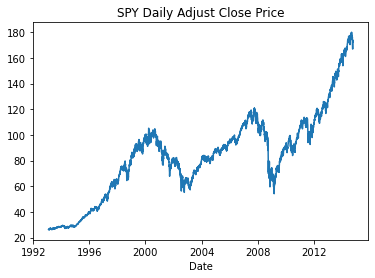

In [25]:
# Plot history of adjusted close price of SPY
sns.lineplot(x = spy['Date'][:split_time], y=x_train.values)
plt.title('SPY Daily Adjust Close Price')

## Create Train Test Split

### SPY Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just show of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

Using a traditional 80:20 train test split our train data will be from day 0 to day 5,474. Our validation set will be the remaining data.

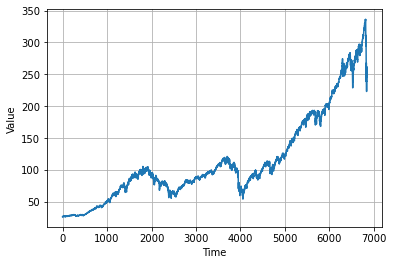

In [5]:
plot_series(time=spy.index,series=spy['Adj Close'])

In [6]:
# Set Split point at 80% of total data leaving the other 20% to be validation data
split_time = round(spy['Adj Close'].index.max() * .8)

# Print out to verify
print('Total days in training set =',split_time,'\n' + '*'*100)

# Create split in data using split point
time_train = spy.index[:split_time]
x_train = spy['Adj Close'][:split_time]

# Print tail to verify you are getting the last 
print('Training Set')
print(x_train.tail())

# Create time span and validation data for validation data now
time_valid = spy.index[split_time:]
x_valid = spy['Adj Close'][split_time:]

# Print out head of validationdata set to see if it picks up right where train set leaves off
print('*'*100)
print('Validation Set')
print(x_valid.head())


Total days in training set = 5474 
****************************************************************************************************
Training Set
5469    166.888809
5470    168.859909
5471    170.499496
5472    173.877258
5473    172.640823
Name: Adj Close, dtype: float64
****************************************************************************************************
Validation Set
5474    174.647720
5475    175.991669
5476    175.749771
5477    177.765656
5478    177.496872
Name: Adj Close, dtype: float64


In [7]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

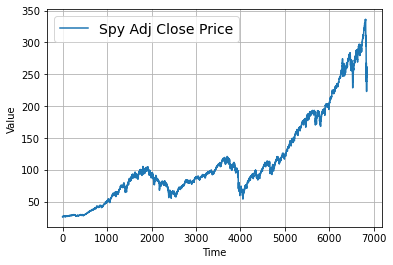

In [8]:
plot_series(time=spy.index,series=spy['Adj Close'], label = 'Spy Adj Close Price')

In [9]:
naive_forecast = spy['Adj Close'][split_time - 1:-1]

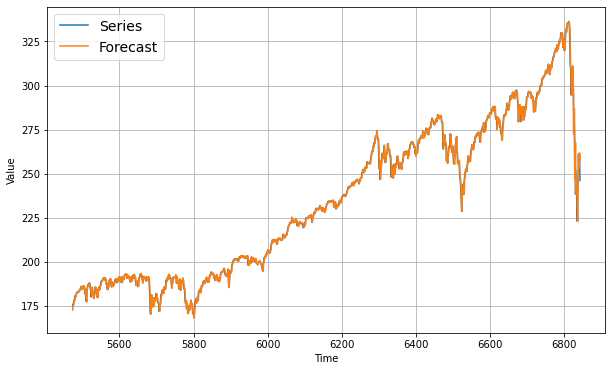

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

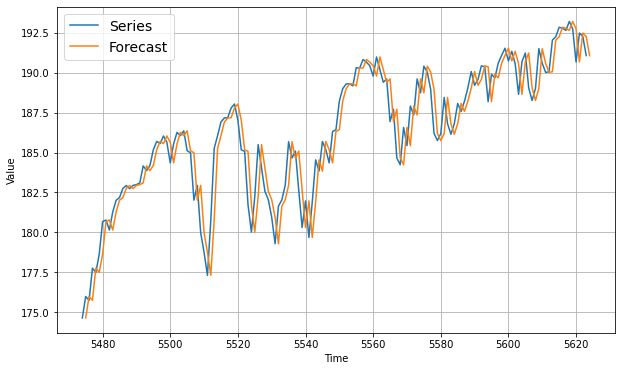

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

### Calculate Error in Naive Model

In [12]:
errors = naive_forecast.values - x_valid.values
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

1.5437803414723057

In [13]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
naive_forecast_mae

1.5437803414723057

In [14]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_valid.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_valid[:3].values))

[172.64082336 174.64772034 175.9916687 ]
[174.64772034 175.9916687  175.74977112]
****************************************************************************************************
[2.00689697 1.34394836 0.24189758]


### Add MAE score to our dictionary

In [15]:
model_mae_scores['Naive Forecast'] = naive_forecast_mae
model_mae_scores

{'Naive Forecast': 1.5437803414723057}

# Monthly Moving Average Model (20 Day MA)

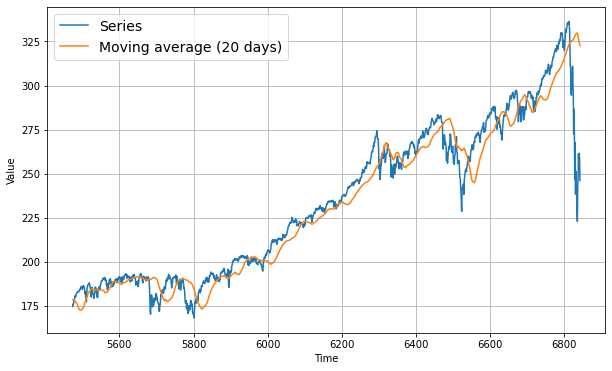

In [16]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = spy['Adj Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_time - window:x_valid.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg_forecast, label="Moving average (20 days)")

In [17]:
ma_20 = keras.metrics.mean_absolute_error(x_valid, moving_avg_forecast).numpy()

model_mae_scores['20 Day Moving Average'] = ma_20
model_mae_scores

{'Naive Forecast': 1.5437803414723057,
 '20 Day Moving Average': 8.162007501684373}

# Weekly Moving Average (5 day MA)

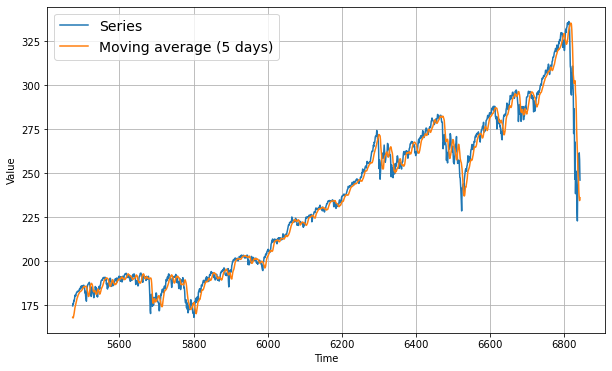

In [18]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = spy['Adj Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_time - window:x_valid.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg_forecast, label="Moving average (5 days)")

In [19]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_valid, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['5 Day Moving Average'] = ma_5
model_mae_scores

{'Naive Forecast': 1.5437803414723057,
 '20 Day Moving Average': 8.162007501684373,
 '5 Day Moving Average': 3.888705627129319}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

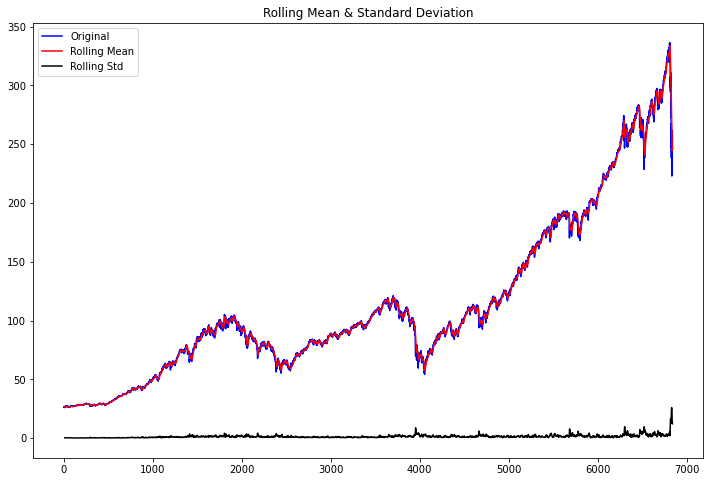

Results of Dickey-Fuller Test:
p-value = 0.9215. The series is likely non-stationary.
Test Statistic                   -0.327558
p-value                           0.921510
#Lags Used                       20.000000
Number of Observations Used    6822.000000
Critical Value (1%)              -3.431309
Critical Value (5%)              -2.861964
Critical Value (10%)             -2.566996
dtype: float64


In [20]:
test_stationarity(spy['Adj Close'])

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference.

In [88]:
# Get the difference of each Adj Close point
spy_close_diff_1 = spy['Adj Close'].diff()
spy_close_diff_1.dropna(inplace=True)

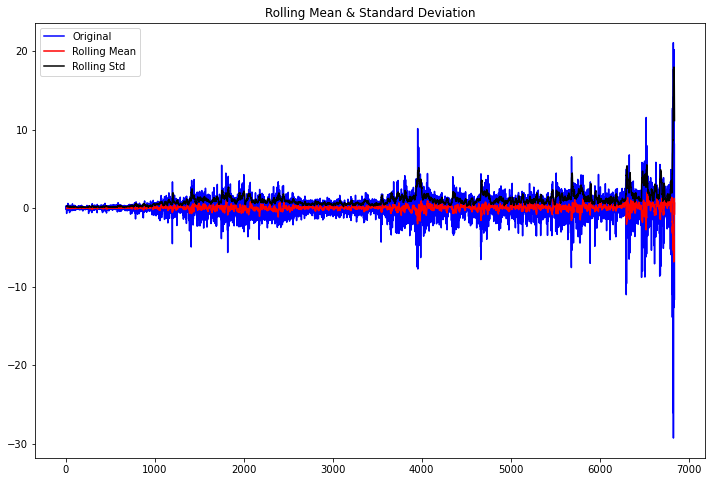

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.665179e+01
p-value                        1.601690e-29
#Lags Used                     2.000000e+01
Number of Observations Used    6.821000e+03
Critical Value (1%)           -3.431309e+00
Critical Value (5%)           -2.861964e+00
Critical Value (10%)          -2.566996e+00
dtype: float64


In [22]:
# Plot the spy Adj Close 1st order difference
test_stationarity(spy_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3 Autocorrelation and Partial autocorrelation

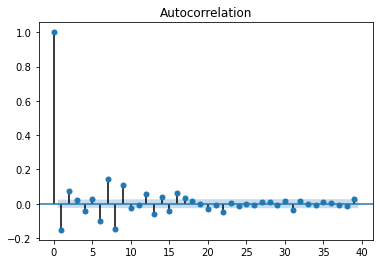

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(spy_close_diff_1)
plt.show()

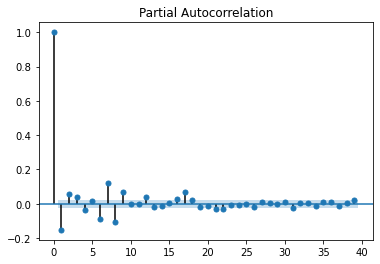

In [24]:
plot_pacf(spy_close_diff_1)
plt.show()

In [25]:
# Establish empty list for for-loop
spy_autocorr = []

# Loop through lag numbers to find the point with highest autocorrelation
for x in list(range(1,101)):
    spy_autocorr.append(spy_close_diff_1.autocorr(lag=x))

# Show the index of the point with the largest autocorrelation value
# 0 indexed so add 1 for correct number of lags
lags = spy_autocorr.index(max(spy_autocorr)) + 1 
print('The best performing lag is number {}'.format(lags))

The best performing lag is number 7


### Testing different arima models

In [106]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
spy_arima = ARIMA(x_train, order=(1,1,1))
spy_arima_fit = spy_arima.fit(disp=0)
print(spy_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 5473
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7799.712
Method:                       css-mle   S.D. of innovations              1.006
Date:                Thu, 27 Aug 2020   AIC                          15607.424
Time:                        15:36:15   BIC                          15633.854
Sample:                             1   HQIC                         15616.645
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0267      0.011      2.394      0.017       0.005       0.049
ar.L1.D.Adj Close     0.6229      0.084      7.403      0.000       0.458       0.788
ma.L1.D.Adj Close    -0.

NormaltestResult(statistic=876.0231547473588, pvalue=5.942770199323262e-191)
This distribution is not a normal distribution


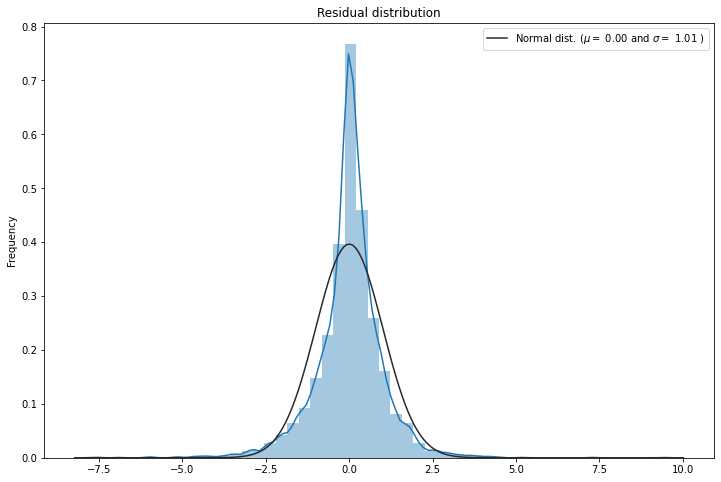

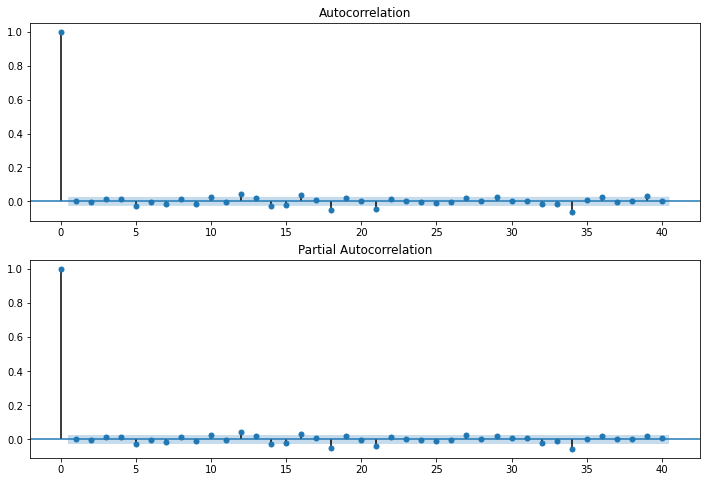

In [107]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = spy_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Step 4 Building the Arima Model and Forecasting

In [109]:
history = [x for x in x_train]
model_predictions = []
N_test_observations = len(x_valid)


for time_point in range(split_time,len(spy)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_valid[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(x_valid, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

C:\Users\blake\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing Mean Squared Error is 1.5397139038888477
Stored 'model_predictions' (list)


In [ ]:
# %store model_predictions
%store -r model_predictions
model_predictions[:5]

In [ ]:
#save model
model_fit.save('arima_715.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_715.pkl')

In [ ]:
# Calculate MAE
arima_mae = mean_absolute_error(x_valid, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

In [87]:
len(model_predictions)

101

In [31]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(x_valid.index, model_predictions, color='blue',label='Predicted Price')
plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

NameError: name 'model_predictions' is not defined

In [32]:
# Find the Error in the ARIMA Model
arima_error = np.array(model_predictions).flatten() - x_valid

NameError: name 'model_predictions' is not defined

#### Show Error in model vs actual

In [33]:
plt.plot(x_valid.index, arima_error, color='blue',label='Predicted Price')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

NameError: name 'arima_error' is not defined

# Deep Learning - RNN Model

In [7]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
keras = tf.keras

In [8]:
# Reshape values
x_train_values = x_train.values.reshape((len(x_train), 1))
x_valid_values = x_valid.values.reshape((len(x_valid), 1))

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))
x_valid_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_valid_scaler.fit_transform(x_valid_values)

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [54]:
train_set

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

In [76]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 20

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
# optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='nadam',
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])


Epoch 1/200
11/11 [==============================] - 1s 52ms/step - loss: 83.1731 - mae: 83.6731
Epoch 2/200
11/11 [==============================] - 1s 52ms/step - loss: 83.1716 - mae: 83.6716
Epoch 3/200
11/11 [==============================] - 1s 51ms/step - loss: 83.1697 - mae: 83.6697
Epoch 4/200
11/11 [==============================] - 1s 52ms/step - loss: 83.1675 - mae: 83.6675
Epoch 5/200
11/11 [==============================] - 1s 52ms/step - loss: 83.1650 - mae: 83.6650
Epoch 6/200
11/11 [==============================] - 1s 56ms/step - loss: 83.1622 - mae: 83.6622
Epoch 7/200
11/11 [==============================] - 1s 55ms/step - loss: 83.1591 - mae: 83.6591
Epoch 8/200
11/11 [==============================] - 1s 56ms/step - loss: 83.1556 - mae: 83.6556
Epoch 9/200
11/11 [==============================] - 1s 54ms/step - loss: 83.1516 - mae: 83.6516
Epoch 10/200
11/11 [==============================] - 1s 53ms/step - loss: 83.1472 - mae: 83.6472
Epoch 11/200
11/11 [=========

11/11 [==============================] - 1s 54ms/step - loss: 54.3293 - mae: 54.8208
Epoch 85/200
11/11 [==============================] - 1s 56ms/step - loss: 52.8104 - mae: 53.3086
Epoch 86/200
11/11 [==============================] - 1s 53ms/step - loss: 51.2162 - mae: 51.7150
Epoch 87/200
11/11 [==============================] - 1s 51ms/step - loss: 49.5103 - mae: 50.0093
Epoch 88/200
11/11 [==============================] - 1s 52ms/step - loss: 47.6952 - mae: 48.1933
Epoch 89/200
11/11 [==============================] - 1s 53ms/step - loss: 45.7818 - mae: 46.2801
Epoch 90/200
11/11 [==============================] - 1s 54ms/step - loss: 43.7724 - mae: 44.2692
Epoch 91/200
11/11 [==============================] - 1s 53ms/step - loss: 41.5495 - mae: 42.0465
Epoch 92/200
11/11 [==============================] - 1s 55ms/step - loss: 40.4183 - mae: 40.9163
Epoch 93/200
11/11 [==============================] - 1s 55ms/step - loss: 37.5718 - mae: 38.0685
Epoch 94/200
11/11 [=============

11/11 [==============================] - 1s 52ms/step - loss: 543.4505 - mae: 543.9505
Epoch 167/200
11/11 [==============================] - 1s 52ms/step - loss: 598.0075 - mae: 598.5075
Epoch 168/200
11/11 [==============================] - 1s 53ms/step - loss: 668.4565 - mae: 668.9565
Epoch 169/200
11/11 [==============================] - 1s 51ms/step - loss: 642.4994 - mae: 642.9993
Epoch 170/200
11/11 [==============================] - 1s 51ms/step - loss: 764.9340 - mae: 765.4338
Epoch 171/200
11/11 [==============================] - 1s 52ms/step - loss: 933.1661 - mae: 933.6661
Epoch 172/200
11/11 [==============================] - 1s 52ms/step - loss: 965.1403 - mae: 965.6403
Epoch 173/200
11/11 [==============================] - 1s 51ms/step - loss: 1141.4879 - mae: 1141.9879
Epoch 174/200
11/11 [==============================] - 1s 52ms/step - loss: 1217.2839 - mae: 1217.7839
Epoch 175/200
11/11 [==============================] - 1s 52ms/step - loss: 1415.4697 - mae: 1415.969

(1e-07, 1.0, 0.0, 100.0)

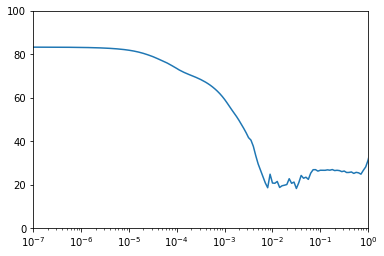

In [77]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, 100])

In [78]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 20

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)
valid_set = window_dataset(x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# Set optimizer
optimizer = keras.optimizers.SGD(lr=3e-2, momentum=0.9)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer='nadam',
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 1s 53ms/step - loss: 79.0370 - mae: 79.5370INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 2s 213ms/step - loss: 79.0370 - mae: 79.5370 - val_loss: 225.3239 - val_mae: 225.8239
Epoch 2/1000
11/11 [==============================] - 2s 225ms/step - loss: 72.7731 - mae: 73.2731 - val_loss: 221.7499 - val_mae: 222.2499
Epoch 3/1000
11/11 [==============================] - 2s 197ms/step - loss: 69.9901 - mae: 70.4901 - val_loss: 219.5271 - val_mae: 220.0271
Epoch 4/1000
11/11 [==============================] - 2s 197ms/step - loss: 68.2235 - mae: 68.7235 - val_loss: 218.1567 - val_mae: 218.6567
Epoch 5/1000
11/11 [==============================] - 2s 201ms/step - loss: 66.9142 - mae: 67.4142 - val_loss: 216.8920 - val_mae: 217.3920
Epoch 6/1000
11/11 [==============================] - 2s 206ms/step - loss: 65.6700 - mae: 66.1700 - val_loss: 215.6676 - val_mae: 216.1676
Epoch 7/1000
11/11 [=======================

Epoch 31/1000
11/11 [==============================] - 3s 247ms/step - loss: 43.6742 - mae: 44.1707 - val_loss: 190.2697 - val_mae: 190.7697
Epoch 32/1000
11/11 [==============================] - 2s 199ms/step - loss: 43.0886 - mae: 43.5877 - val_loss: 189.4088 - val_mae: 189.9088
Epoch 33/1000
11/11 [==============================] - 2s 198ms/step - loss: 42.5149 - mae: 43.0140 - val_loss: 188.5534 - val_mae: 189.0534
Epoch 34/1000
11/11 [==============================] - 2s 206ms/step - loss: 41.9441 - mae: 42.4429 - val_loss: 187.7026 - val_mae: 188.2026
Epoch 35/1000
11/11 [==============================] - 2s 199ms/step - loss: 41.2033 - mae: 41.7023 - val_loss: 186.8591 - val_mae: 187.3591
Epoch 36/1000
11/11 [==============================] - 3s 247ms/step - loss: 39.6037 - mae: 40.0988 - val_loss: 185.9157 - val_mae: 186.4157
Epoch 37/1000
11/11 [==============================] - 2s 199ms/step - loss: 38.1403 - mae: 38.6302 - val_loss: 184.9229 - val_mae: 185.4229
Epoch 38/1000

Epoch 61/1000
11/11 [==============================] - 2s 202ms/step - loss: 21.0074 - mae: 21.4846 - val_loss: 162.2086 - val_mae: 162.7086
Epoch 62/1000
11/11 [==============================] - 2s 200ms/step - loss: 20.4910 - mae: 20.9699 - val_loss: 161.3750 - val_mae: 161.8750
Epoch 63/1000
11/11 [==============================] - 2s 200ms/step - loss: 19.8533 - mae: 20.3253 - val_loss: 160.5434 - val_mae: 161.0434
Epoch 64/1000
11/11 [==============================] - 2s 197ms/step - loss: 19.3877 - mae: 19.8605 - val_loss: 159.7278 - val_mae: 160.2278
Epoch 65/1000
11/11 [==============================] - 3s 237ms/step - loss: 18.8421 - mae: 19.3098 - val_loss: 158.9225 - val_mae: 159.4225
Epoch 66/1000
11/11 [==============================] - 2s 200ms/step - loss: 18.4504 - mae: 18.9240 - val_loss: 158.1300 - val_mae: 158.6300
Epoch 67/1000
11/11 [==============================] - 2s 198ms/step - loss: 17.9736 - mae: 18.4478 - val_loss: 157.3460 - val_mae: 157.8460
Epoch 68/1000

Epoch 91/1000
11/11 [==============================] - 2s 198ms/step - loss: 11.0163 - mae: 11.4830 - val_loss: 142.0627 - val_mae: 142.5627
Epoch 92/1000
11/11 [==============================] - 2s 196ms/step - loss: 10.5691 - mae: 11.0219 - val_loss: 141.5759 - val_mae: 142.0759
Epoch 93/1000
11/11 [==============================] - 2s 198ms/step - loss: 10.4691 - mae: 10.9218 - val_loss: 141.0933 - val_mae: 141.5933
Epoch 94/1000
11/11 [==============================] - 3s 236ms/step - loss: 10.3469 - mae: 10.7990 - val_loss: 140.6204 - val_mae: 141.1204
Epoch 95/1000
11/11 [==============================] - 2s 201ms/step - loss: 10.2801 - mae: 10.7417 - val_loss: 140.1584 - val_mae: 140.6584
Epoch 96/1000
11/11 [==============================] - 2s 202ms/step - loss: 10.1259 - mae: 10.5838 - val_loss: 139.7042 - val_mae: 140.2042
Epoch 97/1000
11/11 [==============================] - 2s 198ms/step - loss: 9.8631 - mae: 10.3116 - val_loss: 139.2546 - val_mae: 139.7546
Epoch 98/1000


Epoch 121/1000
11/11 [==============================] - 2s 204ms/step - loss: 7.9160 - mae: 8.3729 - val_loss: 130.9389 - val_mae: 131.4389
Epoch 122/1000
11/11 [==============================] - 2s 202ms/step - loss: 7.6638 - mae: 8.1138 - val_loss: 130.6164 - val_mae: 131.1164
Epoch 123/1000
11/11 [==============================] - 3s 243ms/step - loss: 7.5878 - mae: 8.0323 - val_loss: 130.2901 - val_mae: 130.7901
Epoch 124/1000
11/11 [==============================] - 2s 202ms/step - loss: 7.6414 - mae: 8.0873 - val_loss: 129.9735 - val_mae: 130.4735
Epoch 125/1000
11/11 [==============================] - 2s 203ms/step - loss: 7.6526 - mae: 8.1112 - val_loss: 129.6739 - val_mae: 130.1739
Epoch 126/1000
11/11 [==============================] - 2s 204ms/step - loss: 7.3977 - mae: 7.8473 - val_loss: 129.4094 - val_mae: 129.9094
Epoch 127/1000
11/11 [==============================] - 2s 204ms/step - loss: 7.3320 - mae: 7.7749 - val_loss: 129.1420 - val_mae: 129.6420
Epoch 128/1000
11/11

11/11 [==============================] - 2s 204ms/step - loss: 6.3290 - mae: 6.7732 - val_loss: 123.0892 - val_mae: 123.5892
Epoch 152/1000
11/11 [==============================] - 2s 202ms/step - loss: 6.1425 - mae: 6.5795 - val_loss: 122.8500 - val_mae: 123.3500
Epoch 153/1000
11/11 [==============================] - 3s 249ms/step - loss: 6.1660 - mae: 6.6085 - val_loss: 122.6108 - val_mae: 123.1108
Epoch 154/1000
11/11 [==============================] - 2s 199ms/step - loss: 6.2176 - mae: 6.6643 - val_loss: 122.3765 - val_mae: 122.8765
Epoch 155/1000
11/11 [==============================] - 2s 201ms/step - loss: 6.1137 - mae: 6.5595 - val_loss: 122.1433 - val_mae: 122.6433
Epoch 156/1000
11/11 [==============================] - 2s 199ms/step - loss: 5.9942 - mae: 6.4261 - val_loss: 121.8957 - val_mae: 122.3957
Epoch 157/1000
11/11 [==============================] - 2s 199ms/step - loss: 6.0760 - mae: 6.5198 - val_loss: 121.6495 - val_mae: 122.1495
Epoch 158/1000
11/11 [=============

11/11 [==============================] - 2s 219ms/step - loss: 5.1490 - mae: 5.5781 - val_loss: 116.2442 - val_mae: 116.7442
Epoch 182/1000
11/11 [==============================] - 2s 210ms/step - loss: 5.3133 - mae: 5.7558 - val_loss: 115.9888 - val_mae: 116.4888
Epoch 183/1000
11/11 [==============================] - 3s 250ms/step - loss: 5.0998 - mae: 5.5351 - val_loss: 115.7583 - val_mae: 116.2583
Epoch 184/1000
11/11 [==============================] - 2s 208ms/step - loss: 5.0862 - mae: 5.5228 - val_loss: 115.5405 - val_mae: 116.0405
Epoch 185/1000
11/11 [==============================] - 2s 209ms/step - loss: 5.0098 - mae: 5.4447 - val_loss: 115.3018 - val_mae: 115.8018
Epoch 186/1000
11/11 [==============================] - 2s 204ms/step - loss: 5.0393 - mae: 5.4773 - val_loss: 115.0788 - val_mae: 115.5788
Epoch 187/1000
11/11 [==============================] - 2s 207ms/step - loss: 4.9191 - mae: 5.3499 - val_loss: 114.8620 - val_mae: 115.3620
Epoch 188/1000
11/11 [=============

11/11 [==============================] - 2s 197ms/step - loss: 4.2686 - mae: 4.7136 - val_loss: 109.7677 - val_mae: 110.2677
Epoch 212/1000
11/11 [==============================] - 2s 197ms/step - loss: 4.0836 - mae: 4.5126 - val_loss: 109.5546 - val_mae: 110.0546
Epoch 213/1000
11/11 [==============================] - 3s 238ms/step - loss: 4.1691 - mae: 4.6085 - val_loss: 109.3570 - val_mae: 109.8570
Epoch 214/1000
11/11 [==============================] - 2s 200ms/step - loss: 4.0652 - mae: 4.4935 - val_loss: 109.1370 - val_mae: 109.6370
Epoch 215/1000
11/11 [==============================] - 2s 198ms/step - loss: 4.0468 - mae: 4.4797 - val_loss: 108.9284 - val_mae: 109.4284
Epoch 216/1000
11/11 [==============================] - 2s 196ms/step - loss: 4.0549 - mae: 4.4918 - val_loss: 108.7157 - val_mae: 109.2157
Epoch 217/1000
11/11 [==============================] - 2s 199ms/step - loss: 4.0909 - mae: 4.5293 - val_loss: 108.5057 - val_mae: 109.0057
Epoch 218/1000
11/11 [=============

11/11 [==============================] - 2s 203ms/step - loss: 3.5915 - mae: 4.0280 - val_loss: 103.3068 - val_mae: 103.8068
Epoch 242/1000
11/11 [==============================] - 2s 205ms/step - loss: 3.4946 - mae: 3.9251 - val_loss: 103.0806 - val_mae: 103.5807
Epoch 243/1000
11/11 [==============================] - 3s 246ms/step - loss: 3.4861 - mae: 3.9208 - val_loss: 102.8600 - val_mae: 103.3600
Epoch 244/1000
11/11 [==============================] - 2s 205ms/step - loss: 3.4323 - mae: 3.8585 - val_loss: 102.6118 - val_mae: 103.1118
Epoch 245/1000
11/11 [==============================] - 2s 202ms/step - loss: 3.3975 - mae: 3.8206 - val_loss: 102.3769 - val_mae: 102.8769
Epoch 246/1000
11/11 [==============================] - 2s 202ms/step - loss: 3.5249 - mae: 3.9628 - val_loss: 102.1508 - val_mae: 102.6508
Epoch 247/1000
11/11 [==============================] - 2s 198ms/step - loss: 3.3648 - mae: 3.7886 - val_loss: 101.9133 - val_mae: 102.4133
Epoch 248/1000
11/11 [=============

11/11 [==============================] - 2s 203ms/step - loss: 2.9917 - mae: 3.4232 - val_loss: 96.6699 - val_mae: 97.1699
Epoch 272/1000
11/11 [==============================] - 2s 205ms/step - loss: 3.0725 - mae: 3.5036 - val_loss: 96.4453 - val_mae: 96.9453
Epoch 273/1000
11/11 [==============================] - 3s 244ms/step - loss: 2.9452 - mae: 3.3678 - val_loss: 96.2362 - val_mae: 96.7362
Epoch 274/1000
11/11 [==============================] - 2s 203ms/step - loss: 2.9111 - mae: 3.3349 - val_loss: 96.0421 - val_mae: 96.5421
Epoch 275/1000
11/11 [==============================] - 2s 203ms/step - loss: 2.9715 - mae: 3.4009 - val_loss: 95.8135 - val_mae: 96.3135
Epoch 276/1000
11/11 [==============================] - 2s 199ms/step - loss: 2.9915 - mae: 3.4222 - val_loss: 95.6241 - val_mae: 96.1241
Epoch 277/1000
11/11 [==============================] - 2s 203ms/step - loss: 2.9397 - mae: 3.3745 - val_loss: 95.4105 - val_mae: 95.9105
Epoch 278/1000
11/11 [===========================

11/11 [==============================] - 2s 197ms/step - loss: 2.6425 - mae: 3.0710 - val_loss: 90.5600 - val_mae: 91.0600
Epoch 302/1000
11/11 [==============================] - 2s 196ms/step - loss: 2.5513 - mae: 2.9789 - val_loss: 90.3421 - val_mae: 90.8421
Epoch 303/1000
11/11 [==============================] - 3s 236ms/step - loss: 2.6420 - mae: 3.0715 - val_loss: 90.1647 - val_mae: 90.6647
Epoch 304/1000
11/11 [==============================] - 2s 202ms/step - loss: 2.5954 - mae: 3.0252 - val_loss: 89.9650 - val_mae: 90.4650
Epoch 305/1000
11/11 [==============================] - 2s 204ms/step - loss: 2.5406 - mae: 2.9639 - val_loss: 89.8075 - val_mae: 90.3075
Epoch 306/1000
11/11 [==============================] - 2s 198ms/step - loss: 2.6548 - mae: 3.0902 - val_loss: 89.6177 - val_mae: 90.1177
Epoch 307/1000
11/11 [==============================] - 2s 203ms/step - loss: 2.5100 - mae: 2.9389 - val_loss: 89.4631 - val_mae: 89.9631
Epoch 308/1000
11/11 [===========================

11/11 [==============================] - 2s 207ms/step - loss: 2.3263 - mae: 2.7573 - val_loss: 85.3141 - val_mae: 85.8141
Epoch 332/1000
11/11 [==============================] - 2s 204ms/step - loss: 2.3464 - mae: 2.7758 - val_loss: 85.1731 - val_mae: 85.6731
Epoch 333/1000
11/11 [==============================] - 3s 247ms/step - loss: 2.2916 - mae: 2.7149 - val_loss: 84.9767 - val_mae: 85.4767
Epoch 334/1000
11/11 [==============================] - 2s 206ms/step - loss: 2.3268 - mae: 2.7558 - val_loss: 84.8158 - val_mae: 85.3158
Epoch 335/1000
11/11 [==============================] - 2s 206ms/step - loss: 2.2640 - mae: 2.6928 - val_loss: 84.6496 - val_mae: 85.1496
Epoch 336/1000
11/11 [==============================] - 2s 203ms/step - loss: 2.3379 - mae: 2.7638 - val_loss: 84.4764 - val_mae: 84.9764
Epoch 337/1000
11/11 [==============================] - 2s 200ms/step - loss: 2.2898 - mae: 2.7166 - val_loss: 84.3116 - val_mae: 84.8116
Epoch 338/1000
11/11 [===========================

11/11 [==============================] - 2s 202ms/step - loss: 2.1158 - mae: 2.5395 - val_loss: 80.0337 - val_mae: 80.5337
Epoch 362/1000
11/11 [==============================] - 2s 202ms/step - loss: 2.0659 - mae: 2.4935 - val_loss: 79.8677 - val_mae: 80.3677
Epoch 363/1000
11/11 [==============================] - 3s 248ms/step - loss: 2.1258 - mae: 2.5533 - val_loss: 79.6957 - val_mae: 80.1957
Epoch 364/1000
11/11 [==============================] - 2s 205ms/step - loss: 2.1018 - mae: 2.5281 - val_loss: 79.5424 - val_mae: 80.0424
Epoch 365/1000
11/11 [==============================] - 2s 206ms/step - loss: 2.1608 - mae: 2.5966 - val_loss: 79.3167 - val_mae: 79.8167
Epoch 366/1000
11/11 [==============================] - 2s 201ms/step - loss: 2.0646 - mae: 2.4873 - val_loss: 79.1833 - val_mae: 79.6833
Epoch 367/1000
11/11 [==============================] - 2s 202ms/step - loss: 2.0352 - mae: 2.4658 - val_loss: 78.9677 - val_mae: 79.4677
Epoch 368/1000
11/11 [===========================

11/11 [==============================] - 2s 199ms/step - loss: 1.9040 - mae: 2.3306 - val_loss: 75.1288 - val_mae: 75.6288
Epoch 392/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.8997 - mae: 2.3295 - val_loss: 74.9800 - val_mae: 75.4800
Epoch 393/1000
11/11 [==============================] - 3s 238ms/step - loss: 1.8283 - mae: 2.2482 - val_loss: 74.8122 - val_mae: 75.3122
Epoch 394/1000
11/11 [==============================] - 2s 198ms/step - loss: 1.9535 - mae: 2.3883 - val_loss: 74.6588 - val_mae: 75.1588
Epoch 395/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.8374 - mae: 2.2597 - val_loss: 74.5511 - val_mae: 75.0511
Epoch 396/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.9230 - mae: 2.3533 - val_loss: 74.4117 - val_mae: 74.9117
Epoch 397/1000
11/11 [==============================] - 2s 198ms/step - loss: 1.9234 - mae: 2.3465 - val_loss: 74.2767 - val_mae: 74.7767
Epoch 398/1000
11/11 [===========================

11/11 [==============================] - 2s 196ms/step - loss: 1.7561 - mae: 2.1801 - val_loss: 71.2482 - val_mae: 71.7482
Epoch 422/1000
11/11 [==============================] - 2s 196ms/step - loss: 1.8842 - mae: 2.3149 - val_loss: 71.2013 - val_mae: 71.7013
Epoch 423/1000
11/11 [==============================] - 3s 234ms/step - loss: 1.7486 - mae: 2.1749 - val_loss: 71.0377 - val_mae: 71.5377
Epoch 424/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.7280 - mae: 2.1443 - val_loss: 70.9313 - val_mae: 71.4313
Epoch 425/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.9331 - mae: 2.3691 - val_loss: 70.8390 - val_mae: 71.3390
Epoch 426/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.7715 - mae: 2.1985 - val_loss: 70.7559 - val_mae: 71.2559
Epoch 427/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.7495 - mae: 2.1723 - val_loss: 70.6245 - val_mae: 71.1245
Epoch 428/1000
11/11 [===========================

11/11 [==============================] - 2s 198ms/step - loss: 1.6491 - mae: 2.0676 - val_loss: 68.1529 - val_mae: 68.6529
Epoch 452/1000
11/11 [==============================] - 2s 196ms/step - loss: 1.7188 - mae: 2.1481 - val_loss: 68.0585 - val_mae: 68.5585
Epoch 453/1000
11/11 [==============================] - 3s 236ms/step - loss: 1.6468 - mae: 2.0660 - val_loss: 67.9899 - val_mae: 68.4899
Epoch 454/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.7237 - mae: 2.1459 - val_loss: 67.8947 - val_mae: 68.3947
Epoch 455/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.7744 - mae: 2.2006 - val_loss: 67.8688 - val_mae: 68.3688
Epoch 456/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.7346 - mae: 2.1555 - val_loss: 67.7159 - val_mae: 68.2159
Epoch 457/1000
11/11 [==============================] - 2s 198ms/step - loss: 1.6982 - mae: 2.1158 - val_loss: 67.6846 - val_mae: 68.1846
Epoch 458/1000
11/11 [===========================

11/11 [==============================] - 2s 201ms/step - loss: 1.6067 - mae: 2.0306 - val_loss: 65.5697 - val_mae: 66.0697
Epoch 482/1000
11/11 [==============================] - 2s 198ms/step - loss: 1.6773 - mae: 2.1016 - val_loss: 65.5620 - val_mae: 66.0620
Epoch 483/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.6198 - mae: 2.0379 - val_loss: 65.4528 - val_mae: 65.9528
Epoch 484/1000
11/11 [==============================] - 3s 237ms/step - loss: 1.6606 - mae: 2.0822 - val_loss: 65.3533 - val_mae: 65.8532
Epoch 485/1000
11/11 [==============================] - 2s 202ms/step - loss: 1.7535 - mae: 2.1735 - val_loss: 65.3136 - val_mae: 65.8136
Epoch 486/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.7115 - mae: 2.1326 - val_loss: 65.2757 - val_mae: 65.7757
Epoch 487/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.6598 - mae: 2.0801 - val_loss: 65.1475 - val_mae: 65.6475
Epoch 488/1000
11/11 [===========================

Epoch 513/1000
11/11 [==============================] - 2s 207ms/step - loss: 1.5900 - mae: 2.0160 - val_loss: 63.1152 - val_mae: 63.6144
Epoch 514/1000
11/11 [==============================] - 2s 202ms/step - loss: 1.6055 - mae: 2.0267 - val_loss: 63.0465 - val_mae: 63.5456
Epoch 515/1000
11/11 [==============================] - 2s 201ms/step - loss: 1.5897 - mae: 2.0171 - val_loss: 62.9981 - val_mae: 63.4971
Epoch 516/1000
11/11 [==============================] - 3s 241ms/step - loss: 1.6020 - mae: 2.0221 - val_loss: 62.9860 - val_mae: 63.4849
Epoch 517/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.5942 - mae: 2.0194 - val_loss: 62.8822 - val_mae: 63.3811
Epoch 518/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.6958 - mae: 2.1179 - val_loss: 62.8350 - val_mae: 63.3338
Epoch 519/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.6647 - mae: 2.0849 - val_loss: 62.7972 - val_mae: 63.2960
Epoch 520/1000
11/11 [============

11/11 [==============================] - 2s 197ms/step - loss: 1.5554 - mae: 1.9706 - val_loss: 61.2414 - val_mae: 61.7406
Epoch 545/1000
11/11 [==============================] - 2s 196ms/step - loss: 1.6516 - mae: 2.0757 - val_loss: 61.2266 - val_mae: 61.7260
Epoch 546/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.6032 - mae: 2.0271 - val_loss: 61.2077 - val_mae: 61.7070
Epoch 547/1000
11/11 [==============================] - 2s 196ms/step - loss: 1.5556 - mae: 1.9718 - val_loss: 61.0885 - val_mae: 61.5878
Epoch 548/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.6241 - mae: 2.0435 - val_loss: 61.0959 - val_mae: 61.5952
Epoch 549/1000
11/11 [==============================] - 3s 235ms/step - loss: 1.5266 - mae: 1.9418 - val_loss: 60.9977 - val_mae: 61.4970
Epoch 550/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.5168 - mae: 1.9305 - val_loss: 61.0215 - val_mae: 61.5209
Epoch 551/1000
11/11 [=============================

11/11 [==============================] - 1s 64ms/step - loss: 1.5864 - mae: 2.0096 - val_loss: 59.9179 - val_mae: 60.4165
Epoch 579/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.5215 - mae: 1.9410 - val_loss: 59.8463 - val_mae: 60.3450
Epoch 580/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.5089 - mae: 1.9229 - val_loss: 59.8441 - val_mae: 60.3427
Epoch 581/1000
11/11 [==============================] - 2s 201ms/step - loss: 1.4810 - mae: 1.8956 - val_loss: 59.7745 - val_mae: 60.2731
Epoch 582/1000
11/11 [==============================] - 3s 239ms/step - loss: 1.5098 - mae: 1.9254 - val_loss: 59.6828 - val_mae: 60.1812
Epoch 583/1000
11/11 [==============================] - 1s 67ms/step - loss: 1.5862 - mae: 2.0052 - val_loss: 59.7580 - val_mae: 60.2568
Epoch 584/1000
11/11 [==============================] - 2s 209ms/step - loss: 1.5872 - mae: 2.0058 - val_loss: 59.6384 - val_mae: 60.1368
Epoch 585/1000
11/11 [=============================

11/11 [==============================] - 1s 63ms/step - loss: 1.5345 - mae: 1.9517 - val_loss: 59.0874 - val_mae: 59.5864
Epoch 616/1000
11/11 [==============================] - 3s 235ms/step - loss: 1.5857 - mae: 2.0022 - val_loss: 59.0104 - val_mae: 59.5093
Epoch 617/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.6079 - mae: 2.0344 - val_loss: 59.0349 - val_mae: 59.5339
Epoch 618/1000
11/11 [==============================] - 1s 63ms/step - loss: 1.5304 - mae: 1.9457 - val_loss: 59.0532 - val_mae: 59.5521
Epoch 619/1000
11/11 [==============================] - 1s 63ms/step - loss: 1.5936 - mae: 2.0188 - val_loss: 59.0335 - val_mae: 59.5324
Epoch 620/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.5361 - mae: 1.9519 - val_loss: 59.0161 - val_mae: 59.5149
Epoch 621/1000
11/11 [==============================] - 2s 196ms/step - loss: 1.5602 - mae: 1.9840 - val_loss: 59.0032 - val_mae: 59.5021
Epoch 622/1000
11/11 [==============================] 

11/11 [==============================] - 1s 64ms/step - loss: 1.5416 - mae: 1.9647 - val_loss: 58.6507 - val_mae: 59.1491
Epoch 659/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4995 - mae: 1.9186 - val_loss: 58.6418 - val_mae: 59.1403
Epoch 660/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.5610 - mae: 1.9798 - val_loss: 58.6815 - val_mae: 59.1799
Epoch 661/1000
11/11 [==============================] - 2s 198ms/step - loss: 1.4888 - mae: 1.9015 - val_loss: 58.6295 - val_mae: 59.1278
Epoch 662/1000
11/11 [==============================] - 2s 202ms/step - loss: 1.4791 - mae: 1.8940 - val_loss: 58.6163 - val_mae: 59.1146
Epoch 663/1000
11/11 [==============================] - 1s 69ms/step - loss: 1.4860 - mae: 1.9021 - val_loss: 58.6237 - val_mae: 59.1221
Epoch 664/1000
11/11 [==============================] - 1s 66ms/step - loss: 1.4714 - mae: 1.8828 - val_loss: 58.6358 - val_mae: 59.1343
Epoch 665/1000
11/11 [==============================] 

11/11 [==============================] - 1s 64ms/step - loss: 1.5091 - mae: 1.9256 - val_loss: 58.4025 - val_mae: 58.9005
Epoch 705/1000
11/11 [==============================] - 1s 66ms/step - loss: 1.4948 - mae: 1.9109 - val_loss: 58.4304 - val_mae: 58.9282
Epoch 706/1000
11/11 [==============================] - 2s 202ms/step - loss: 1.5399 - mae: 1.9617 - val_loss: 58.3774 - val_mae: 58.8753
Epoch 707/1000
11/11 [==============================] - 2s 197ms/step - loss: 1.5419 - mae: 1.9579 - val_loss: 58.3294 - val_mae: 58.8271
Epoch 708/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.5575 - mae: 1.9735 - val_loss: 58.4073 - val_mae: 58.9053
Epoch 709/1000
11/11 [==============================] - 2s 199ms/step - loss: 1.5662 - mae: 1.9840 - val_loss: 58.3136 - val_mae: 58.8111
Epoch 710/1000
11/11 [==============================] - 2s 204ms/step - loss: 1.5720 - mae: 1.9895 - val_loss: 58.3122 - val_mae: 58.8099
Epoch 711/1000
11/11 [==============================

Epoch 751/1000
11/11 [==============================] - 1s 67ms/step - loss: 1.4877 - mae: 1.8993 - val_loss: 58.1063 - val_mae: 58.6038
Epoch 752/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.5348 - mae: 1.9525 - val_loss: 58.0864 - val_mae: 58.5840
Epoch 753/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4869 - mae: 1.8984 - val_loss: 58.1646 - val_mae: 58.6623
Epoch 754/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4767 - mae: 1.8905 - val_loss: 58.1628 - val_mae: 58.6607
Epoch 755/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.5037 - mae: 1.9172 - val_loss: 58.1308 - val_mae: 58.6285
Epoch 756/1000
11/11 [==============================] - 1s 66ms/step - loss: 1.4854 - mae: 1.9023 - val_loss: 58.0876 - val_mae: 58.5852
Epoch 757/1000
11/11 [==============================] - 1s 66ms/step - loss: 1.4987 - mae: 1.9135 - val_loss: 58.1352 - val_mae: 58.6328
Epoch 758/1000
11/11 [===================

Epoch 804/1000
11/11 [==============================] - 1s 67ms/step - loss: 1.4763 - mae: 1.8880 - val_loss: 57.9202 - val_mae: 58.4180
Epoch 805/1000
11/11 [==============================] - 1s 67ms/step - loss: 1.5160 - mae: 1.9291 - val_loss: 57.9488 - val_mae: 58.4466
Epoch 806/1000
11/11 [==============================] - 2s 205ms/step - loss: 1.5011 - mae: 1.9149 - val_loss: 57.8721 - val_mae: 58.3698
Epoch 807/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.4929 - mae: 1.9097 - val_loss: 57.8739 - val_mae: 58.3717
Epoch 808/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.4676 - mae: 1.8793 - val_loss: 57.8783 - val_mae: 58.3761
Epoch 809/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4584 - mae: 1.8707 - val_loss: 57.8810 - val_mae: 58.3787
Epoch 810/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4722 - mae: 1.8872 - val_loss: 57.9294 - val_mae: 58.4271
Epoch 811/1000
11/11 [==================

Epoch 857/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.5302 - mae: 1.9544 - val_loss: 57.8998 - val_mae: 58.3975
Epoch 858/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.4757 - mae: 1.8917 - val_loss: 57.8837 - val_mae: 58.3814
Epoch 859/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.5121 - mae: 1.9285 - val_loss: 57.9032 - val_mae: 58.4009
Epoch 860/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.4816 - mae: 1.8954 - val_loss: 57.8400 - val_mae: 58.3377
Epoch 861/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.4708 - mae: 1.8841 - val_loss: 57.9526 - val_mae: 58.4505
Epoch 862/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.4725 - mae: 1.8858 - val_loss: 57.8300 - val_mae: 58.3278
Epoch 863/1000
11/11 [==============================] - 2s 201ms/step - loss: 1.4942 - mae: 1.9123 - val_loss: 57.7072 - val_mae: 58.2048
Epoch 864/1000
11/11 [==================

Epoch 910/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.5051 - mae: 1.9202 - val_loss: 57.6926 - val_mae: 58.1906
Epoch 911/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4984 - mae: 1.9141 - val_loss: 57.7004 - val_mae: 58.1983
Epoch 912/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4889 - mae: 1.9067 - val_loss: 57.6580 - val_mae: 58.1558
Epoch 913/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4692 - mae: 1.8872 - val_loss: 57.6783 - val_mae: 58.1762
Epoch 914/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4657 - mae: 1.8774 - val_loss: 57.7049 - val_mae: 58.2028
Epoch 915/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4973 - mae: 1.9136 - val_loss: 57.6693 - val_mae: 58.1672
Epoch 916/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.5003 - mae: 1.9146 - val_loss: 57.6063 - val_mae: 58.1041
Epoch 917/1000
11/11 [===================

Epoch 968/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4861 - mae: 1.8989 - val_loss: 57.6609 - val_mae: 58.1588
Epoch 969/1000
11/11 [==============================] - 1s 63ms/step - loss: 1.4910 - mae: 1.9051 - val_loss: 57.6237 - val_mae: 58.1216
Epoch 970/1000
11/11 [==============================] - 1s 66ms/step - loss: 1.4940 - mae: 1.9097 - val_loss: 57.6537 - val_mae: 58.1516
Epoch 971/1000
11/11 [==============================] - 1s 65ms/step - loss: 1.4948 - mae: 1.9085 - val_loss: 57.6209 - val_mae: 58.1188
Epoch 972/1000
11/11 [==============================] - 1s 63ms/step - loss: 1.4986 - mae: 1.9143 - val_loss: 57.6197 - val_mae: 58.1176
Epoch 973/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4654 - mae: 1.8781 - val_loss: 57.6508 - val_mae: 58.1486
Epoch 974/1000
11/11 [==============================] - 1s 64ms/step - loss: 1.4836 - mae: 1.8970 - val_loss: 57.7205 - val_mae: 58.2183
Epoch 975/1000
11/11 [===================

In [79]:
model = keras.models.load_model("my_checkpoint")

In [80]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [85]:
rnn_forecast = model_forecast(
    model,
    spy['Adj Close'][split_time - window_size:-1],
    window_size)[:, 0]

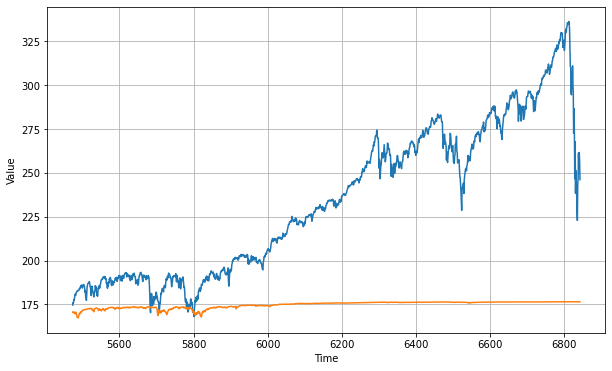

In [86]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [94]:
rnn_forecast_mae = mean_absolute_error(x_valid, rnn_forecast)

In [95]:
rnn_forecast_mae

59.44331024370549

### RNN With Stationary Data

In [90]:
# Bring back our first order difference (stationary) data
stationary_train = spy_close_diff_1[split_time:]
stationary_valid = spy_close_diff_1[:split_time]

In [96]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 20

# create windowed tensor data set from series
train_set = window_dataset(stationary_valid, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
# optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='nadam',
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


Epoch 1/200
11/11 [==============================] - 1s 53ms/step - loss: 0.4828 - mae: 0.8348
Epoch 2/200
11/11 [==============================] - 1s 50ms/step - loss: 0.4826 - mae: 0.8346
Epoch 3/200
11/11 [==============================] - 1s 50ms/step - loss: 0.4824 - mae: 0.8343
Epoch 4/200
11/11 [==============================] - 1s 50ms/step - loss: 0.4821 - mae: 0.8340
Epoch 5/200
11/11 [==============================] - 1s 50ms/step - loss: 0.4818 - mae: 0.8336
Epoch 6/200
11/11 [==============================] - 1s 49ms/step - loss: 0.4815 - mae: 0.8332
Epoch 7/200
11/11 [==============================] - 1s 50ms/step - loss: 0.4812 - mae: 0.8328
Epoch 8/200
11/11 [==============================] - 1s 50ms/step - loss: 0.4807 - mae: 0.8323
Epoch 9/200
11/11 [==============================] - 1s 49ms/step - loss: 0.4803 - mae: 0.8317
Epoch 10/200
11/11 [==============================] - 1s 50ms/step - loss: 0.4798 - mae: 0.8311
Epoch 11/200
11/11 [=============================

11/11 [==============================] - 1s 49ms/step - loss: 0.3653 - mae: 0.6781
Epoch 87/200
11/11 [==============================] - 1s 49ms/step - loss: 0.3712 - mae: 0.6859
Epoch 88/200
11/11 [==============================] - 1s 49ms/step - loss: 0.3799 - mae: 0.6971
Epoch 89/200
11/11 [==============================] - 1s 50ms/step - loss: 0.3651 - mae: 0.6765
Epoch 90/200
11/11 [==============================] - 1s 50ms/step - loss: 0.3654 - mae: 0.6779
Epoch 91/200
11/11 [==============================] - 1s 50ms/step - loss: 0.3659 - mae: 0.6794
Epoch 92/200
11/11 [==============================] - 1s 50ms/step - loss: 0.3643 - mae: 0.6758
Epoch 93/200
11/11 [==============================] - 1s 49ms/step - loss: 0.3637 - mae: 0.6757
Epoch 94/200
11/11 [==============================] - 1s 49ms/step - loss: 0.3666 - mae: 0.6805
Epoch 95/200
11/11 [==============================] - 1s 51ms/step - loss: 0.3709 - mae: 0.6860
Epoch 96/200
11/11 [==============================] -

11/11 [==============================] - 1s 50ms/step - loss: 409.3926 - mae: 409.8925
Epoch 170/200
11/11 [==============================] - 1s 49ms/step - loss: 531.6676 - mae: 532.1676
Epoch 171/200
11/11 [==============================] - 1s 50ms/step - loss: 721.7291 - mae: 722.2291
Epoch 172/200
11/11 [==============================] - 1s 50ms/step - loss: 874.1998 - mae: 874.6998
Epoch 173/200
11/11 [==============================] - 1s 50ms/step - loss: 943.9261 - mae: 944.4260
Epoch 174/200
11/11 [==============================] - 1s 49ms/step - loss: 1054.2488 - mae: 1054.7488
Epoch 175/200
11/11 [==============================] - 1s 50ms/step - loss: 1184.2037 - mae: 1184.7037
Epoch 176/200
11/11 [==============================] - 1s 50ms/step - loss: 1156.0399 - mae: 1156.5399
Epoch 177/200
11/11 [==============================] - 1s 50ms/step - loss: 1011.9747 - mae: 1012.4746
Epoch 178/200
11/11 [==============================] - 1s 49ms/step - loss: 1056.8481 - mae: 1057

(1e-07, 1.0, 0.0, 1.0)

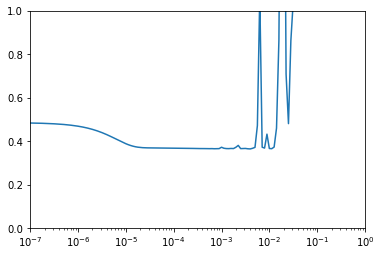

In [99]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, 1])

In [145]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 20

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)
valid_set = window_dataset(x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  keras.layers.BatchNormalization(),
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# Set optimizer
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer='nadam',
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 1s 54ms/step - loss: 82.9792 - mae: 83.4792INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 3s 232ms/step - loss: 82.9792 - mae: 83.4792 - val_loss: 236.3080 - val_mae: 236.8080
Epoch 2/1000
11/11 [==============================] - 2s 217ms/step - loss: 75.2086 - mae: 75.7086 - val_loss: 230.7447 - val_mae: 231.2447
Epoch 3/1000
11/11 [==============================] - 2s 213ms/step - loss: 71.0961 - mae: 71.5961 - val_loss: 226.5983 - val_mae: 227.0983
Epoch 4/1000
11/11 [==============================] - 2s 217ms/step - loss: 69.2267 - mae: 69.7267 - val_loss: 223.0344 - val_mae: 223.5344
Epoch 5/1000
11/11 [==============================] - 2s 216ms/step - loss: 67.6991 - mae: 68.1991 - val_loss: 220.5531 - val_mae: 221.0531
Epoch 6/1000
11/11 [==============================] - 3s 270ms/step - loss: 66.2329 - mae: 66.7329 - val_loss: 218.4122 - val_mae: 218.9122
Epoch 7/1000
11/11 [=======================

Epoch 31/1000
11/11 [==============================] - 2s 215ms/step - loss: 42.6526 - mae: 43.1516 - val_loss: 188.6544 - val_mae: 189.1544
Epoch 32/1000
11/11 [==============================] - 2s 218ms/step - loss: 42.0367 - mae: 42.5355 - val_loss: 187.7114 - val_mae: 188.2114
Epoch 33/1000
11/11 [==============================] - 2s 225ms/step - loss: 41.4310 - mae: 41.9306 - val_loss: 186.7828 - val_mae: 187.2828
Epoch 34/1000
11/11 [==============================] - 3s 228ms/step - loss: 40.8328 - mae: 41.3319 - val_loss: 185.8671 - val_mae: 186.3671
Epoch 35/1000
11/11 [==============================] - 3s 231ms/step - loss: 40.2426 - mae: 40.7411 - val_loss: 184.9631 - val_mae: 185.4631
Epoch 36/1000
11/11 [==============================] - 3s 232ms/step - loss: 39.6656 - mae: 40.1640 - val_loss: 184.0732 - val_mae: 184.5732
Epoch 37/1000
11/11 [==============================] - 3s 282ms/step - loss: 39.1038 - mae: 39.6024 - val_loss: 183.1953 - val_mae: 183.6953
Epoch 38/1000

11/11 [==============================] - 1s 67ms/step - loss: 27.6422 - mae: 28.1387 - val_loss: 235.9666 - val_mae: 236.4666
Epoch 68/1000
11/11 [==============================] - 1s 68ms/step - loss: 27.4535 - mae: 27.9499 - val_loss: 233.5189 - val_mae: 234.0189
Epoch 69/1000
11/11 [==============================] - 1s 67ms/step - loss: 27.2896 - mae: 27.7856 - val_loss: 232.8236 - val_mae: 233.3236
Epoch 70/1000
11/11 [==============================] - 1s 67ms/step - loss: 27.1254 - mae: 27.6211 - val_loss: 231.2609 - val_mae: 231.7609
Epoch 71/1000
11/11 [==============================] - 1s 66ms/step - loss: 26.9783 - mae: 27.4743 - val_loss: 230.5982 - val_mae: 231.0982
Epoch 72/1000
11/11 [==============================] - 1s 66ms/step - loss: 26.8469 - mae: 27.3429 - val_loss: 230.6100 - val_mae: 231.1100
Epoch 73/1000
11/11 [==============================] - 1s 67ms/step - loss: 26.7245 - mae: 27.2202 - val_loss: 230.7551 - val_mae: 231.2551
Epoch 74/1000
11/11 [=============

In [146]:
model = keras.models.load_model("my_checkpoint")

In [147]:
rnn_forecast = model_forecast(
    model,
    spy['Adj Close'][split_time - window_size:-1],
    window_size)[:, 0]

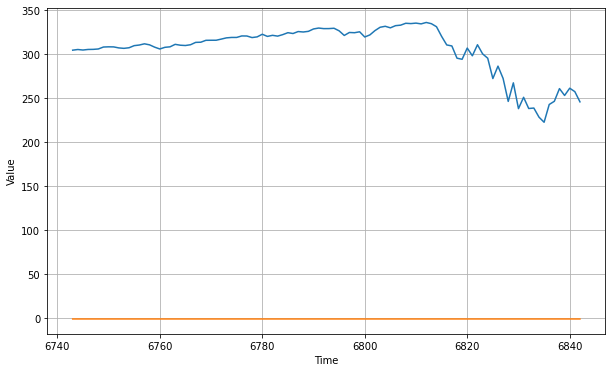

In [148]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], rnn_preds[-100:])

In [114]:
rnn_preds = rnn_forecast.flatten()

In [119]:
update = x_valid + rnn_preds

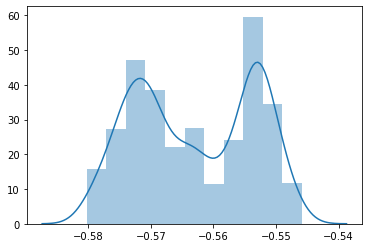

In [126]:
sns.distplot(rnn_preds)

# LSTM Model

# CNN - Wavenet Model